In [60]:
import os
import pickle
import matplotlib.pyplot as plt
import glob
import ast
from datetime import datetime
from tabulate import tabulate

import numpy as np

#import tikzplotlib
from IPython.core.display import HTML

display(HTML("<style>.container {width:90% !important;}</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from operator import itemgetter

# path and env name
# print where the jupyter notebook is running
path = '../results/'    # the folder where all kinds of experiments you ever ran are stored
stderr_pathstderr_path= os.path.join(os.path.expanduser("~"), 'workdir/')

xp_env = ['qtCat']  # the folder this set of experiments is stored in

indicator = "valid_arithmetic" # the indicator to plot

xp_id_filter=[] # filter out experiments with these ids
xp_id_selector=[] # select only experiments with these ids
unwanted_args = ['dump_path']

# global variables
var_args = set()
all_args = {}


# list experiments
xps = [(env, xp) for env in xp_env for xp in os.listdir(path+'/'+env) if (len(xp_id_selector)==0 or xp in xp_id_selector) and (len(xp_id_filter)==0 or not xp in xp_id_filter)]
names = [path + env + '/' + xp for (env, xp) in xps]
print(len(names),"experiments found")

# read all args
pickled_xp = 0
for name in names:
    pa = name+'/params.pkl'
    if not os.path.exists(pa):
        print("Unpickled experiment: ", name)
        continue
    pk = pickle.load(open(pa,'rb'))
    all_args.update(pk.__dict__)
    pickled_xp += 1
print(pickled_xp, "pickled experiments found")
print()

# find variable args
for name in names:
    pa = name+'/params.pkl'
    if not os.path.exists(pa):
        continue
    pk = pickle.load(open(pa,'rb'))
    for key,value in all_args.items():
        if key in pk.__dict__ and value == pk.__dict__[key]:
            continue
        if key not in unwanted_args:
            var_args.add(key)

print("common args")
for key in all_args:
    if key not in unwanted_args and key not in var_args:
        print(key,"=", all_args[key])
print()
            
print(len(var_args)," variables params out of", len(all_args))
print(var_args)



          

1 experiments found
1 pickled experiments found

common args
exp_name = qtCat
save_periodic = 0
exp_id = 1
report_loss_every = 200
epoch_size = 10000
max_epoch = 100000
stopping_criterion = 
validation_metrics = 
enc_emb_dim = 256
dec_emb_dim = 256
n_enc_layers = 4
n_dec_layers = 4
n_enc_heads = 8
n_dec_heads = 8
xav_init = False
n_enc_hidden_layers = 1
n_dec_hidden_layers = 1
gelu_activation = False
dropout = 0
max_src_len = 0
norm_attention = False
attention_dropout = 0
architecture = encoder_decoder
lstm = False
GRU = False
bidirectional = False
lstm_hidden_dim = 2048
share_inout_emb = True
sinusoidal_embeddings = False
enc_has_pos_emb = True
dec_has_pos_emb = True
enc_loop_idx = -1
dec_loop_idx = -1
enc_loops = 1
dec_loops = 1
gated = False
enc_gated = False
dec_gated = False
scalar_gate = False
biased_gates = False
gate_bias = 0
enc_act = False
dec_act = False
act_threshold = 0.01
act_ponder_coupling = 0.01
act_biased = False
act_bias = 0
fp16 = False
amp = -1
num_workers = 1
env_

In [61]:
def vars_from_env_xp(env, xp):
    res = {}
    pa = path+env+'/'+xp+'/params.pkl'
    if not os.path.exists(pa):
        print("pickle", pa, "not found")
        return res
    pk = pickle.load(open(pa,'rb'))
    for key in var_args:
        if key in pk.__dict__: 
            res[key] = pk.__dict__[key]
        else:
            res[key] = None
    return res

def get_start_time(line):
    parsed_line = line.split(" ")
    dt = datetime.strptime(parsed_line[2]+' '+parsed_line[3],"%m/%d/%y %H:%M:%S")
    try:
        idx = parsed_line.index("epoch")
        curr_epoch = int(parsed_line[idx+1])
    except ValueError:
        curr_epoch = ""
    return dt, curr_epoch


def read_xp(env, xp, indics, max_epoch=None):
    res = {"env":env, "xp": xp, "stderr":False, "log":False, "error":False}
    stderr_file = os.path.join(os.path.expanduser("~"), 'workdir/'+env+'/*/'+xp+'.stderr')
    # stderr_file = stderr_path+env+'/*/'+xp+'.stderr'
    nb_stderr =len(glob.glob(stderr_file))
    if nb_stderr > 1:
        print("duplicate stderr", env, xp)
        return res
    for name in glob.glob(stderr_file):
        with open(name, 'rt') as f:
            res["stderr"]=True
            errlines = []
            cuda = False
            terminated = False
            forced = False
            for line in f:
                if line.find("RuntimeError:") >= 0:
                    errlines.append(line)
                if line.find("CUDA out of memory") >= 0:
                    cuda = True
                if line.find("Exited with exit code 1") >=0:
                    # print(stderr_file)
                    terminated = True
                
                if line.find("Force Terminated") >=0:
                    # print(stderr_file)
                    forced = True
            res["forced"] = forced
                
            res["terminated"] = terminated
            if len(errlines) > 0:    
                res["error"] = True
                res["runtime_errors"] = errlines
                res["oom"] = cuda 
                if not cuda:
                    print(stderr_file,"runtime error no oom")
               
    pa = path+env+'/'+xp+'/train.log'
#    print(pa)
    if not os.path.exists(pa):
        return res
    res["log"] = True
    with open(pa, 'rt') as f:
        series = []
        train_loss=[]
        for ind in indics:
            series.append([])
        best_val = -1.0
        best_xel = 999999999.0
        best_epoch = -1
        epoch = -1
        val = -1
        ended = False
        nanfound = False
        res["curr_epoch"]=-1
        res["train_time"]=0
        res["eval_time"]=0
        res["pred_nr"]=[]
        nb_sig10 = 0
        nb_sig15 = 0
        counter = 0
        counting = False
        for line in f:
            try:
                if counting:
                    counter += 1
                if line.find("Signal handler called with signal 10") >= 0:
                    nb_sig10 += 1
                if line.find("Signal handler called with signal 15") >= 0:
                    nb_sig15 += 1
                if line.find("Stopping criterion has been below its best value for more than") >=0:
                    ended = True
                elif line.find("============ Starting epoch") >=0:
                    dt, curr_epoch = get_start_time(line)
                    if curr_epoch == max_epoch: break
                    res["start_time"] = dt
                    if curr_epoch >0 and curr_epoch == res["curr_epoch"]+1:
                        res["eval_time"] += (dt - res["end_time"]).total_seconds()
                    res["curr_epoch"] = curr_epoch
                elif line.find("============ End of epoch") >=0:
                    dt, curr_epoch = get_start_time(line)
                    if curr_epoch != res["curr_epoch"]:
                        print("epoch mismatch", curr_epoch,"in", env,",", xp)
                    else:
                        res["end_time"] = dt
                        res["train_time"] += (dt-res["start_time"]).total_seconds()
                elif line.find("- model LR:") >=0:
                    loss = line.split(" ")[-5].strip()
                    train_loss.append(None if loss == 'nan' else float(loss)) 
                elif line.find("- LR:") >=0:
                    loss = line.split(" ")[-4].strip()
                    if loss == "predictions.":
                        print(line)
                    else:    
                        train_loss.append(None if loss == 'nan' else float(loss)) 
                elif line.find('- test predicted pairs') >=0:
                    counter = 0
                    counting = True
                else:                 
                    pos = line.find('__log__:')
                    if pos >=0:
                        counting = False
                        res['pred_nr'].append(counter/100.0)
                        if line[pos+8:].find(': NaN,') >= 0:
                            nanfound = True
                            line = line.replace(': NaN,',': -1.0,')
                        dic = ast.literal_eval(line[pos+8:])
                        epoch = dic["epoch"]
                        if not indicator+"_"+indics[0] in dic: 
                            continue
                        if not indicator+"_"+indics[1] in dic: 
                            continue
                        val = dic[indicator+"_"+indics[0]]
                        xel = dic[indicator+"_"+indics[1]]
                        if xel < best_xel:
                            best_xel= xel
                        if val > best_val:
                            best_val = val
                            best_epoch = epoch 
                            res["best_dic"] = dic
                        for i, indic in enumerate(indics):
                            if indicator+"_"+indic in dic:
                                series[i].append(dic[indicator+"_"+indic])
                                
            except Exception as e:
                print(e, "exception in", env, xp)
                continue  
            except:
                print(line)
                continue
        res["nans"] = nanfound
        res["ended"] = (ended or (nb_sig15 > nb_sig10))
        res["last_epoch"] = epoch
        res["last_acc"] = "{:.2f}".format(val)
        res["best_epoch"] = best_epoch
        res["best_acc"] = float("{:.2f}".format(best_val))
        res["best_xeloss"] = "{:.2f}".format(best_xel)
        res["train_loss"]=train_loss
        res["avg_d"] = np.median(res['pred_nr'])
        res["last_d"] = res['pred_nr'][-1] if len(res['pred_nr']) > 0 else -1
        if epoch >=0:
            res["train_time"] /= (epoch+1)
            res["eval_time"] /= (epoch+1)
        res["train_time"] = int(res["train_time"]+0.5) 
        res["eval_time"] = int(res["eval_time"]+0.5) 
            
        for i,indic in enumerate(indics):
            res["last_"+indic] = "{:.2f}".format(series[i][-1]) if len(series[i])>0 else '0'
            res["best_"+indic] = "{:.2f}".format(max(series[i])) if len(series[i])>0 else '0'
            res[indic] = series[i]
            if len(series[i])!= epoch + 1:
                print("mismatch in nr of epochs",env, xp, epoch+1, len(series[i]), indic)      
    return res


    
# read experiments
data = []
indics = ["acc","xe_loss", "perfect", "correct"]
for (env, xp) in xps:
    res = read_xp(env, xp, indics, None)
    res.update(vars_from_env_xp(env, xp))
    data.append(res)


print(len(data), "experiments read")
print(len([d for d in data if d["stderr"] is False]),"stderr not found")
print(len([d for d in data if d["error"] is True]),"runtime errors")
print(len([d for d in data if "oom" in d and d["oom"] is True]),"oom errors")
print(len([d for d in data if "terminated" in d and d["terminated"] is True]),"exit code 1")
print(len([d for d in data if "forced" in d and d["forced"] is True]),"Force Terminated")
print(len([d for d in data if "last_epoch" in d and d["last_epoch"] >= 0]),"started XP")
print(len([d for d in data if "ended" in d and d["ended"] is True]),"ended XP")
print(len([d for d in data if "best_acc" in d and float(d["best_acc"]) > 0.0]),"began predicting")





1 experiments read
1 stderr not found
0 runtime errors
0 oom errors
0 exit code 1
0 Force Terminated
1 started XP
0 ended XP
1 began predicting


CUDA out of memory (0)

Forced terminations (0)

Not started (0)

Running experiments (1)

+----------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
| best_acc | best_epoch | best_xeloss | ended | last_epoch | last_acc | last_xe_loss | nans  | error | train_time | eval_time | best_correct | best_perfect |
+----------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
|  78.50   |     54     |    0.52     | False |     57     |  77.90   |     0.56     | False | False |     21     |     2     |    78.50     |    78.50     |
+----------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
acc


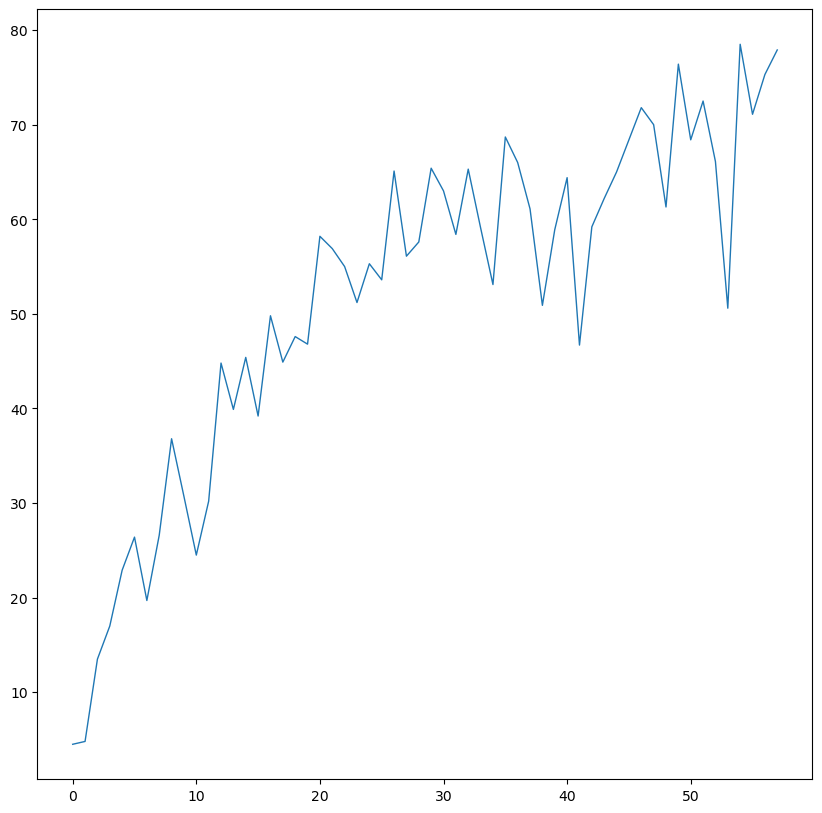

perfect


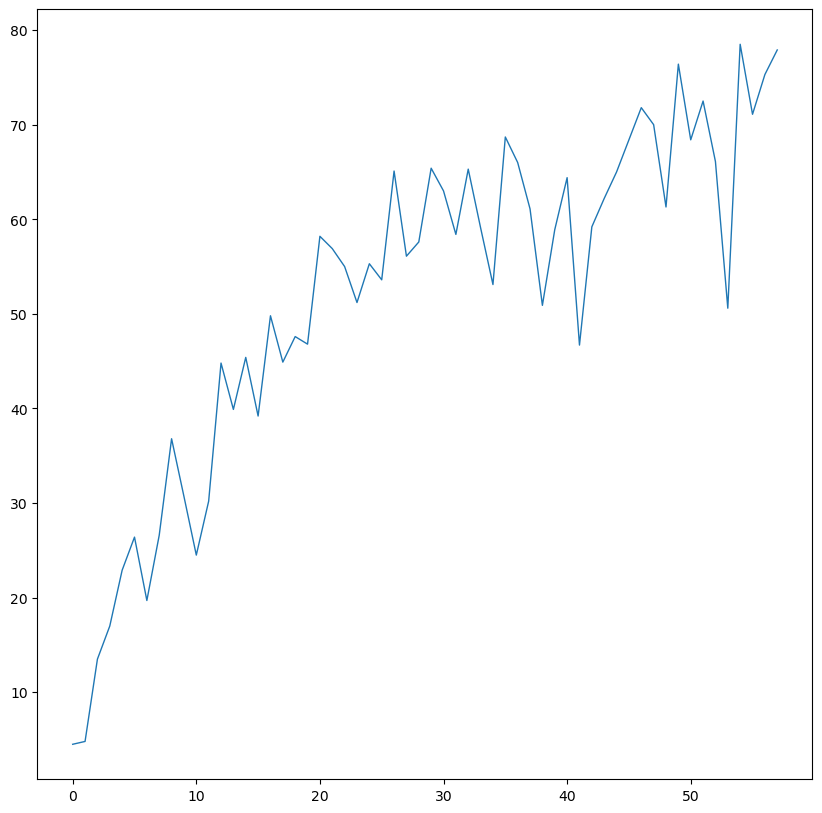

correct


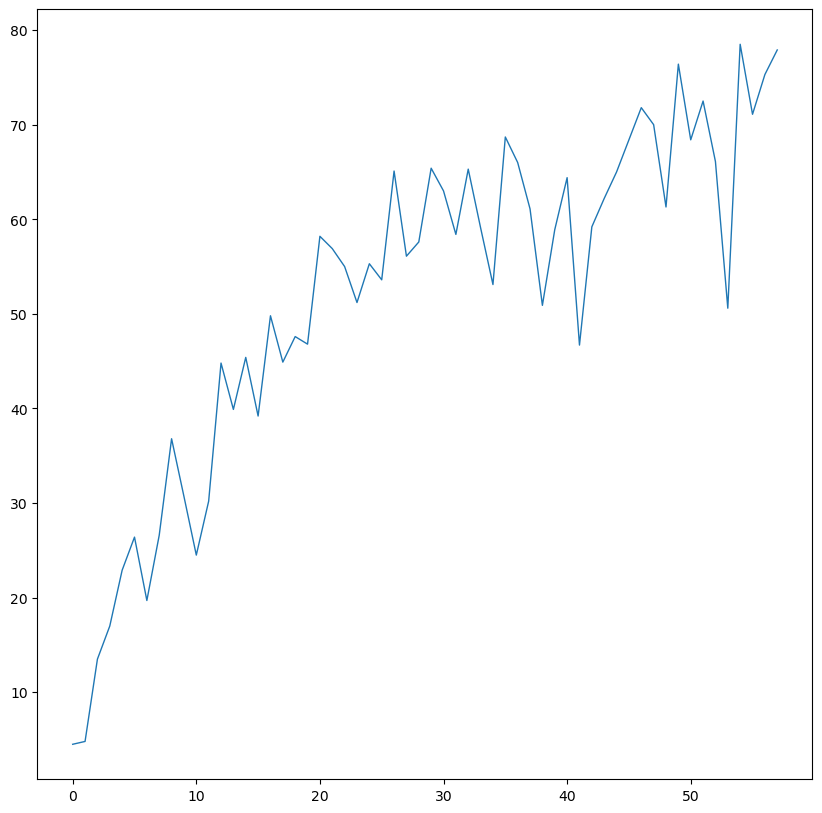

xe_loss


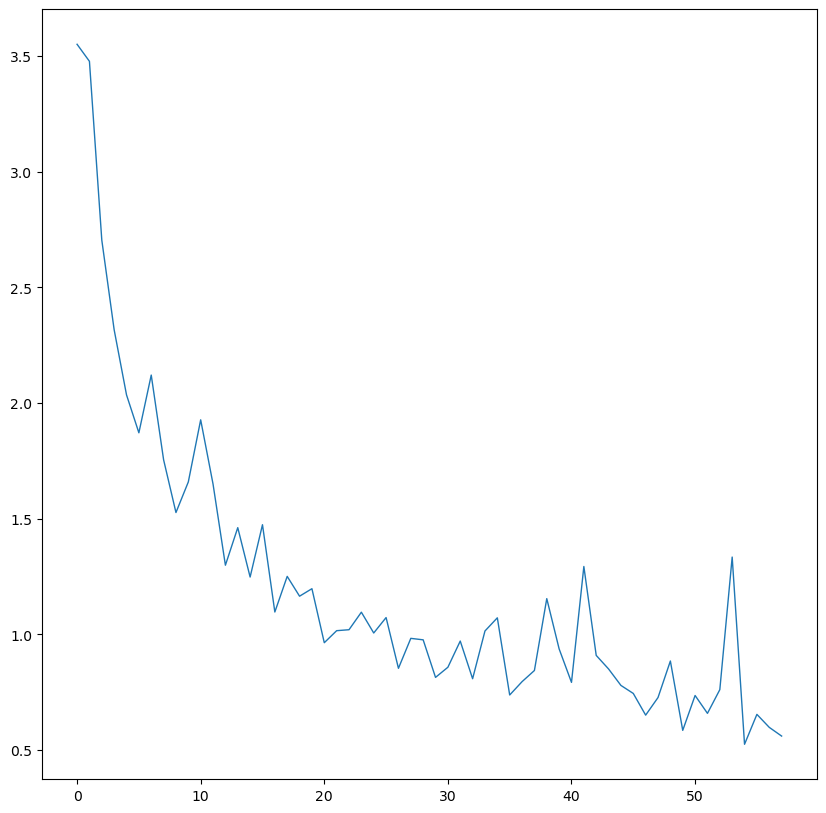

train_loss


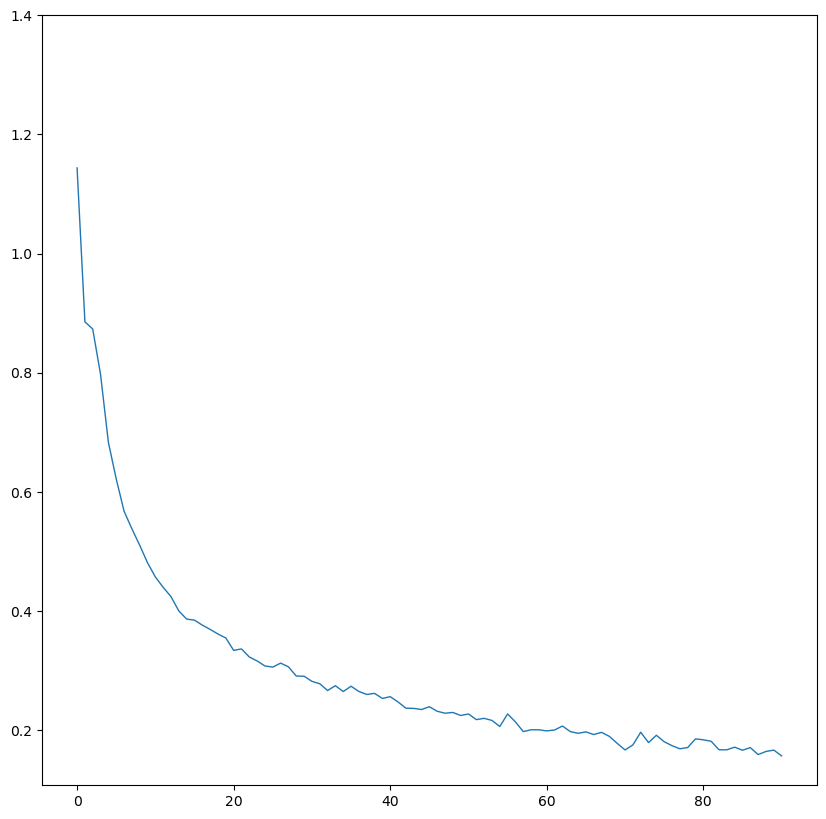

+----------+-------------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
| best_acc | first epoch | best_epoch | best_xeloss | ended | last_epoch | last_acc | last_xe_loss | nans  | error | train_time | eval_time | best_correct | best_perfect |
+----------+-------------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
|  78.50   |    10000    |     54     |    0.52     | False |     57     |  77.90   |     0.56     | False | False |     21     |     2     |    78.50     |    78.50     |
+----------+-------------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------+--------------+--------------+
+----------+-------------+------------+-------------+-------+------------+----------+--------------+-------+-------+------------+-----------

In [62]:
import numpy as np


def compose(f,g):
    return lambda x : f(g(x))

def print_table(data, args, sort=False):
    res = []
    for d in data:
        line = [d[v] if v in d else None for v in args]
        res.append(line)
    if sort:
        res = sorted(res, key=compose(float,itemgetter(0)), reverse=True)
    print(tabulate(res,headers=args,tablefmt="pretty"))


    
def speed_table(data, args, indic, sort=False, percent=95):
    res = []
    for d in data:
        
        if indic in d:
            line = [d[v] if v in d else None for v in args]
            val= 10000
            for i,v in enumerate(d[indic]):
                if v >= percent and i < val:
                    val = i
                    
            line.insert(1,val)
            res.append(line)
    e= args.copy()
    e.insert(1,'first epoch')
    if sort:
        res = sorted(res, key=compose(float,itemgetter(1)), reverse=False)
    print(tabulate(res,headers=e,tablefmt="pretty"))

    
def training_curve(data, indic, beg=0, end=-1, maxval=None, minval=None, export_to=""):
    print(indic)
    for d in data:
        if indic in d:
            if end == -1:
                plt.plot(d[indic][beg:],linewidth=1)
            else:
                plt.plot(d[indic][beg:end],linewidth=1)
    plt.ylim(minval,maxval)
    plt.rcParams['figure.figsize'] = [10,10]
    if export_to != '':
       # print(export_to)
        plt.savefig(export_to,bbox_inches="tight")

    plt.show()


def filter_xp(xp, filt):
    for f in filt:
        if not f in xp:
            return False
        if not xp[f] in filt[f]:
            return False
    return True

def xp_stats(data, splits, best_arg, best_value):
    res_dic = {}
    nb = 0
    for d in data:
        if d[best_arg] < best_value: continue
        nb += 1
        for s in splits:
            if not s in d: continue
            lib=s+':'+str(d[s])
            if lib in res_dic:
                res_dic[lib] += 1
            else:
                res_dic[lib]=1
                
    print()
    print(f"{nb} experiments with accuracy over {best_value}")
    for elem in sorted(res_dic):
        print(elem,' : ',res_dic[elem])
    print()

xp_filter ={} 

#xp_filter.update({"n_enc_layers":[4]})
#xp_filter.update({"enc_emb_dim":[128]})


fdata = [d for d in data if filter_xp(d, xp_filter) is True]

oomtab = [d for d in fdata if d["error"] is True]
print(f"CUDA out of memory ({len(oomtab)})")
print_table(oomtab, var_args)

forcetab = [d for d in fdata if 'forced' in d and d["forced"] is True]
print(f"Forced terminations ({len(forcetab)})")
print_table(forcetab, var_args)

unstartedtab = [d for d in fdata if "last_epoch" in d and d["last_epoch"] < 0] 
print(f"Not started ({len(unstartedtab)})")
print_table(unstartedtab, var_args)

crypto = False
runargs = ["best_acc", "best_epoch","best_xeloss",  "ended", "last_epoch", "last_acc", "last_xe_loss","nans", "error", "train_time", "eval_time"]
runargs.extend(["best_correct", "best_perfect"])
for v in var_args:
    runargs.append(v)
runningtab = [d for d in fdata if "last_epoch" in d and d["last_epoch"] >= 0] 
print(f"Running experiments ({len(runningtab)})")

#splits = ['n_enc_layers','dec_emb_dim','reload_size'] 
#xp_stats(fdata, splits, 'best_acc',90.0)
print()

print_table(runningtab, runargs, sort=True)

training_curve(fdata, "acc",0,-1, None, export_to = "")

training_curve(fdata, "perfect")
training_curve(fdata, "correct")

    

    
training_curve(fdata, "xe_loss", 0) #, None, 0.9* np.min([x for d in fdata for x in d["xe_loss"] if x >0.0]))
training_curve(fdata, "train_loss",0,-1,1.4)


speed_table(runningtab, runargs, "acc", sort=True,percent=99)
speed_table(runningtab, runargs, "acc", sort=True,percent=50)

                   
                   